## 라이브러리 버전 확인

In [2]:
!pip install summa

from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

nltk.download('stopwords')
from nltk.corpus import stopwords
import os
import os.path
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

import requests
from summa.summarizer import summarize

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


# step1. data 수집

- 데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용한다.

https://github.com/sunnysai12345/News_Summary

In [4]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(10)

,headlines,text
68126,"Trailer of Kalki, Richa starrer 'Jia Aur Jia' ...",The trailer of the upcoming Kalki Koechlin and...
30101,"Google now lets iOS users navigate with SUV, s...",Technology giant Google has introduced a new f...
63531,UK helped India in 1984 Operation Blue Star: R...,Former PM Margaret Thatcher-led UK government ...
85961,India reaches rank 15 in global 4G availability,India was ranked 15th in the global 4G availab...
41166,Hyderabad traffic cop feeds homeless woman wit...,A picture of a Hyderabad traffic policeman fee...
76679,"Passenger trashes flight bathroom, assaults cr...",A passenger on a Vancouver-bound WestJet fligh...
23999,Death due to stone pelting is also lynching: U...,Union Minister Rajyavardhan Rathore said that ...
39236,US man infected himself with HIV to give peopl...,A 25-year-old man in the US state of Arkansas ...
87538,Indonesia announces police task force to targe...,An Indonesian police chief on Wednesday announ...
75747,143 scientists have quit DRDO since 2014: Arun...,Union Minister Arun Jaitley informed the Lok S...


- text, headlines의 샘플 수에 대해 알아본다. 

In [5]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


- null data가 있는지 확인해본다.

In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


# 추상적 요약

# step2. data 전처리
- 텍스트를 정규화, 정제한다.
- 불용어를 제거한다.

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


- 불용어의 개수를 확인해준다.

In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

- 데이터 전처리를 위한 함수

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").get_text(separator=" ") # <br />, <a href = ...> 등의 html 태그 공백으로 치환
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

- data의 전처리 속도를 위해 피클로 파일 저장

In [10]:
def load_processedData() :
    file = 'data.pkl'     # 예제 Textfile
    if os.path.isfile(file):
        dt = pd.read_pickle(file)
    else :
        dt = preprocess()
        dt.to_pickle(file)
    return dt

In [12]:
def preprocess() : # 전처리 함수
    dt = data
    clean_text = []
    for index, row in data.iterrows():
        clean_text.append(preprocess_sentence(row['text']))
    print("Text 전처리 후 결과: ", clean_text[:5])

    clean_summary = []
    for index, row in dt.iterrows():
        clean_summary.append(preprocess_sentence(row['headlines'],False))
    print("headlines 전처리 후 결과: ", clean_summary[:5])
    dt['text'] = clean_text
    dt['headlines'] = clean_summary
    # 빈 값을 Null 값으로 변환
    dt.replace('', np.nan, inplace=True)
    dt.dropna(axis=0, inplace=True)
    return dt

In [13]:
data = load_processedData()

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

- 전처리 후 데이터의 전체 길이와 편차를 살펴본다.

text 최소 길이 : 1
text 최대 길이 : 60
text 평균 길이 : 35.09968483123221
summary 최소 길이 : 1
summary 최대 길이 : 16
summary 평균 길이 : 9.299532330215534


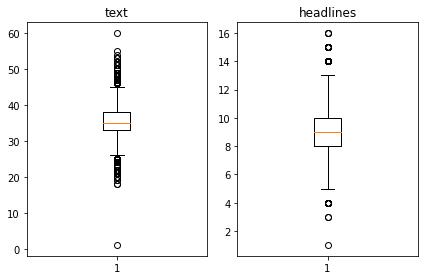

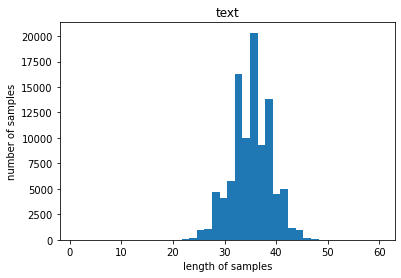

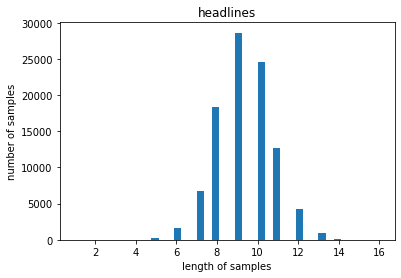

In [14]:
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('text 최소 길이 : {}'.format(np.min(text_len)))
print('text 최대 길이 : {}'.format(np.max(text_len)))
print('text 평균 길이 : {}'.format(np.mean(text_len)))
print('summary 최소 길이 : {}'.format(np.min(summary_len)))
print('summary 최대 길이 : {}'.format(np.max(summary_len)))
print('summary 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- data의 최대길이와 편차 모두 크지않다.
- 그대로 사용.

In [16]:
text_max_len = 60
summary_max_len = 16
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [17]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [18]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[72455 78430 65971 ... 15789 81857 40402]


In [19]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [20]:
# Assuming encoder_input is a list of text data
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input)

# Now you can use src_tokenizer.texts_to_sequences
sequences = src_tokenizer.texts_to_sequences([encoder_input[50]])
print(sequences)

[[129, 2733, 18632, 444, 351, 106, 2457, 3371, 26541, 280, 1527, 97, 123, 154, 108, 480, 94, 59, 444, 2365, 1180, 22931, 280, 1527, 97, 3798, 451, 4154, 6, 9451, 18632, 696, 316]]


In [21]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [22]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('train 데이터의 개수 :', len(encoder_input_train))
print('train 레이블의 개수 :', len(decoder_input_train))
print('test 데이터의 개수 :', len(encoder_input_test))
print('test 레이블의 개수 :', len(decoder_input_test))

train 데이터의 개수 : 78688
train 레이블의 개수 : 78688
test 데이터의 개수 : 19672
test 레이블의 개수 : 19672


In [23]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [24]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69669
등장 빈도가 6번 이하인 희귀 단어의 수: 47540
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22129
단어 집합에서 희귀 단어의 비율: 68.23694900170808
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4979460375452387


In [25]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

- 텍스트 시퀀스를 정수 시퀀스로 변환해준다.

In [26]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2, 3600, 1053, 1476, 567, 30, 3, 885, 401, 374, 529, 827, 617, 529, 8, 143, 698, 69, 2958, 905, 934, 529, 29, 3, 3290, 3, 3, 401, 374, 529], [54, 31, 134, 708, 131, 473, 222, 1722, 422, 161, 113, 482, 4743, 113, 347, 35, 97, 581, 113, 13804, 113, 22, 571, 87, 1025, 426, 134, 511, 3455, 817, 8948, 461, 4091, 1902, 36, 32, 4, 2846, 4155], [947, 556, 121, 290, 4924, 102, 1893, 56, 1480, 190, 4440, 1596, 2799, 3140, 102, 93, 473, 177, 1596, 190, 2894, 1071, 5776, 975, 1616, 5, 34, 2815, 13361, 34, 2815, 617, 473, 1010, 61, 262, 1754, 32, 18342]]


In [27]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [28]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30053
등장 빈도가 4번 이하인 희귀 단어의 수: 18510
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11543
단어 집합에서 희귀 단어의 비율: 61.591188899610685
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.933129153823183


In [29]:
tar_vocab = 11000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 8, 3890, 2170, 1383, 206, 571, 39, 926, 6], [1, 165, 324, 3, 21, 1047, 4, 2345, 36], [1, 1220, 1966, 187, 4508, 1193, 270, 4, 560], [1, 580, 6, 131, 1094, 52, 7, 4509, 937, 915, 825, 25, 4, 210], [1, 1482, 6, 8, 867, 98, 847, 12, 27, 193]]
target
decoder  [[8, 3890, 2170, 1383, 206, 571, 39, 926, 6, 2], [165, 324, 3, 21, 1047, 4, 2345, 36, 2], [1220, 1966, 187, 4508, 1193, 270, 4, 560, 2], [580, 6, 131, 1094, 52, 7, 4509, 937, 915, 825, 25, 4, 210, 2], [1482, 6, 8, 867, 98, 847, 12, 27, 193, 2]]


In [30]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 train 데이터의 개수 :', len(drop_train))
print('삭제할 test 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('train 데이터의 개수 :', len(encoder_input_train))
print('train 레이블의 개수 :', len(decoder_input_train))
print('test 데이터의 개수 :', len(encoder_input_test))
print('test 레이블의 개수 :', len(decoder_input_test))

삭제할 train 데이터의 개수 : 0
삭제할 test 데이터의 개수 : 0
train 데이터의 개수 : 78688
train 레이블의 개수 : 78688
test 데이터의 개수 : 19672
test 레이블의 개수 : 19672


In [31]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

- encoder 설계

In [35]:
embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(text_max_len,))
print(encoder_inputs)
# encoder 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# encoder LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# encoder LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# encoder LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=False, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_output2)

KerasTensor(type_spec=TensorSpec(shape=(None, 60), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")


- decoder 설계

In [36]:
decoder_inputs = Input(shape=(None,))

# decoder 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# decoder LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# decoder 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 60, 128)      2560000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 60, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

- Attention 함수

In [37]:
attn_layer = AdditiveAttention(name='attention_layer')

# encoder, decoder 모든 time step의 hidden state를 attention 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# attention 결과와 decoder hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# decoder 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 60, 128)      2560000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 60, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [38]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 80s 141ms/step - loss: 4.3490 - val_loss: 3.9672
Epoch 2/50
308/308 [==============================] - 44s 144ms/step - loss: 3.8515 - val_loss: 3.6868
Epoch 3/50
308/308 [==============================] - 46s 150ms/step - loss: 3.5970 - val_loss: 3.5095
Epoch 4/50
308/308 [==============================] - 46s 148ms/step - loss: 3.4054 - val_loss: 3.3562
Epoch 5/50
308/308 [==============================] - 46s 149ms/step - loss: 3.2480 - val_loss: 3.2422
Epoch 6/50
308/308 [==============================] - 46s 149ms/step - loss: 3.1170 - val_loss: 3.1597
Epoch 7/50
308/308 [==============================] - 46s 149ms/step - loss: 3.0074 - val_loss: 3.0986
Epoch 8/50
308/308 [==============================] - 46s 149ms/step - loss: 2.9136 - val_loss: 3.0448
Epoch 9/50
308/308 [==============================] - 46s 149ms/step - loss: 2.8312 - val_loss: 2.9990
Epoch 10/50
308/308 [==============================] - 46s 149ms/step - l

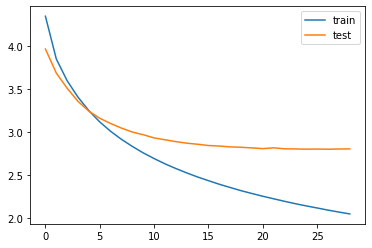

In [39]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [40]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

- encoder 설계

In [41]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# step3. Attention 매커니즘 사용
- seq2seq보다 attention 사용하는것이 더 나은 성능을 낸다.
- attention 을 설계, 사용해본다.

- attention function

In [42]:
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# dscoder 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 decoder 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [43]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

- 원문의 정수 시퀀스를 텍스트 시퀀스로 변환

In [44]:
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

- 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환

In [45]:
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0 and tar_index_to_word[i]!='sostoken'):
            temp = temp + tar_index_to_word[i]+' '
    return temp

# step4. 실제 결과와 요약문 비교하기

- 원래의 headlines와 학습을 통해 얻은 추상적 요약의 결과를 비교해본다

In [54]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("추상 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : mukul choudhary wife serving ips officer announced contest rajasthan assembly elections independent candidate constituency cm vasundhara raje contests choudhary alleged people raje adding husband fights crime corruption shall different way 
실제 요약 : ips officer wife to contest against raj cm vasundhara raje 
추상 요약 :  rajasthan cm announces contest to attend rally


원문 : filmmaker madhur bhandarkar denied claims congress mp jyotiraditya scindia upcoming film indu sarkar set backdrop emergency india fully sponsored certain organisation individual madhur added know made comment without knowing facts known make movies 
실제 요약 : madhur denies cong mp claim that indu sarkar is sponsored 
추상 요약 :  indu sarkar should be sarkar congress mp


원문 : defence acquisition council chaired defence minister nirmala sitharaman cleared acquisitions worth crore biggest procurement approved crore purchase naval utility helicopters built chosen indian private sector company council also approved procureme

- 추상적 요약은 추출적 요약에 비해 문장의 표현력을 다양하게 가져갈 수 있지만 추출적 요약에 비하여 난이도가 높다.

# step5. Summa를 이용하여 추출적 요약하기

- 요약텍스트 return function으로 데이터를 전처리

In [53]:
#텍스트를 입력하면 요약해서 요약텍스트를 리턴해주는 함수
def textSummaryAbs(text) :
    text_preprocess = preprocess_sentence(text)
    text_preprocess = src_tokenizer.texts_to_sequences([text])
    text_preprocess = pad_sequences(text_preprocess, maxlen=text_max_len, padding='post')
    summa = decode_sequence(text_preprocess)
    return summa

textSummaryAbs(data['text'][0])
print(data['headlines'][0])
print("추출 요약 :", summarize(data['text'][0], ratio=0.5) )

upgrad learner switches to career in ml al with salary hike
추출 요약 : 


- 추출적 요약의 경우 원문에서 중요한 문장을 그대로 추출하기 때문에 원문이 충분한 정보와 문맥을 가지고 있어야 한다.
- 추상적 요약을 수행하는 함수를 사용해서 원문의 일부 내용을 삭제하거나 변경할 시 원문의 원래 구조와 문맥이 손실되면 추출적 요약이 제대로 작동하지 않는다.

In [51]:
data_org = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

- 원문의 약 50% 길이로 생성. (ratio = 0.5)

In [55]:
for i in range(50, 100):
    print("원문 :", data_org['text'][i] )
    print('\n')
    print("추상 요약 :", textSummaryAbs(data_org['text'][i]) )
    print("추출 요약 :", summarize(data_org['text'][i], ratio=0.5) )
    print("실제 요약 :", data_org['headlines'][i] )
    print('\n')
    print("-------------------------------------------------------")
    print('\n')

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.


추상 요약 :  yashwant sinha demands probe into alleged power probe
추출 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL


-------------------------------------------------------


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 a

- 추상적 요약의 경우 길이가 상대적으로 추출 요약보다 짧아 비슷한 길이로 비교하기 위하여 ratio를 조정해본다.

In [56]:
for i in range(50, 100):
    print("원문 :", data_org['text'][i] )
    print('\n')
    print("예측 요약 :", textSummaryAbs(data_org['text'][i]) )
    print("추출 요약 :", summarize(data_org['text'][i], ratio=0.3) )
    print("실제 요약 :", data_org['headlines'][i] )
    print('\n')
    print("-------------------------------------------------------")
    print('\n')

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.


예측 요약 :  yashwant sinha demands probe into alleged power probe
추출 요약 : 
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL


-------------------------------------------------------


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight year, delivering 806 aircraft in 201

In [57]:
for i in range(50, 100):
    print("원문 :", data_org['text'][i] )
    print('\n')
    print("예측 요약 :", textSummaryAbs(data_org['text'][i]) )
    print("추출 요약 :", summarize(data_org['text'][i], ratio=0.4) )
    print("실제 요약 :", data_org['headlines'][i] )
    print('\n')
    print("-------------------------------------------------------")
    print('\n')

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.


예측 요약 :  yashwant sinha demands probe into alleged power probe
추출 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL


-------------------------------------------------------


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 a

- ratio을 0.3으로 설정하였을 땐 추출요약이 작동하지 않았다.
- 0.4 로 지정했을 경우 문장이 불완전한 경우가 다수 포착되었다.
    - 문장이 3개 이하로 이루어진 경우 추출 요약이 정상적으로 작동하지 않는 경향으로 보인다.

## 회고
- 피클을 사용하여 파일의 크기를 축소하여 데이터의 전송시간을 줄여 전처리 수행 속도를 높일 수 있었다.
- 추출 요약의 경우 전처리를 거치지 않은 원본데이터나 최소한의 전처리를 수행한 데이터를 사용하는것이 좋다.
- 추상적 요약의 경우 원문의 내용을 기반으로 새로운 문장을 생성하는 형태이다. 원문과 다른 표현이 있었고 상대적으로 원문의 핵심 내용을 잘 파악하지 못한 경우가 많았다.
    - 다소 다른 정보를 포함한 예시들이 존재했다. 
    - 원문 : Gmail on Tuesday faced a global outage, which also affected India, wherein certain users complained they faced a '404 error' message while trying to sign-in to their accounts. The error message read: "The requested URL was not found on this server. That's all we know." Google responded saying "problem with Gmail should be resolved (now). We apologise for the inconvenience".
    - 추상 : twitter users react to users who outage
    - 추출 : Gmail on Tuesday faced a global outage, which also affected India, wherein certain users complained they faced a '404 error' message while trying to sign-in to their accounts.
- 추출적 요약의 경우 추상적 요약보다 요약이 상대적으로 길었다. 세부 정보도 상대적으로 많이 포함되었다. 왜곡이 거의 없다.
    - 대부분의 추출요약은 원문의 중요한 정보를 잘 포착하였다.
    - 다만 비슷한 내용의 요약을 제공한 경우 추상적 요약이더 간결한 결과를 낸 것을 확인할 수 있었다.